In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize,curve_fit
from sklearn.metrics import mean_squared_error ,mean_absolute_error, classification_report, confusion_matrix

In [80]:
df = pd.read_csv("../data/04_cricket_1999to2011.csv")
df.head()

,Match,Date,Innings,Over,Runs,Total.Runs,Innings.Total.Runs,Runs.Remaining,Total.Out,Innings.Total.Out,...,at.bat.won.toss,at.bat.at.home,at.bat.bat.first,chose_bat_1st,chose_bat_2nd,forced_bat_1st,forced_bat_2nd,new.game,Error.In.Data,common.support
0,65193,14/05/1999,1,1,4,4,204,200,0,10,...,0,0,1,0,0,1,0,1,0,1
1,65193,14/05/1999,1,2,2,6,204,198,0,10,...,0,0,1,0,0,1,0,0,0,1
2,65193,14/05/1999,1,3,3,9,204,195,0,10,...,0,0,1,0,0,1,0,0,0,1
3,65193,14/05/1999,1,4,2,20,204,184,0,10,...,0,0,1,0,0,1,0,0,0,1
4,65193,14/05/1999,1,5,6,37,204,167,0,10,...,0,0,1,0,0,1,0,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126768 entries, 0 to 126767
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Match                      126768 non-null  int64  
 1   Date                       126768 non-null  object 
 2   Innings                    126768 non-null  int64  
 3   Over                       126768 non-null  int64  
 4   Runs                       126768 non-null  int64  
 5   Total.Runs                 126768 non-null  int64  
 6   Innings.Total.Runs         126768 non-null  int64  
 7   Runs.Remaining             126768 non-null  int64  
 8   Total.Out                  126768 non-null  int64  
 9   Innings.Total.Out          126768 non-null  int64  
 10  Outs.Remaining             126768 non-null  int64  
 11  Wickets.in.Hand            126768 non-null  int64  
 12  Run.Rate                   126768 non-null  float64
 13  Innings.Run.Rate           12

In [4]:
df = df[df['Error.In.Data']==0]

In [5]:
df['Over.Remaining'] = df['Total.Overs']-df['Over']
df = df[['Innings','Innings.Total.Runs', 'Runs.Remaining','Wickets.in.Hand','Over.Remaining']]
df.head()

,Innings,Innings.Total.Runs,Runs.Remaining,Wickets.in.Hand,Over.Remaining
0,1,204,200,10,49
1,1,204,198,10,48
2,1,204,195,10,47
3,1,204,184,10,46
4,1,204,167,10,45


In [6]:
df1= df[df['Innings']==1]
df1.head()

,Innings,Innings.Total.Runs,Runs.Remaining,Wickets.in.Hand,Over.Remaining
0,1,204,200,10,49
1,1,204,198,10,48
2,1,204,195,10,47
3,1,204,184,10,46
4,1,204,167,10,45


In [7]:

in_params  =[]
def getMeanRunByWicketRemaining():
    '''in_params = array of(z1,z2,...z10,L)'''
    for i in range(1,11):
        in_params.append(np.mean(df[df['Wickets.in.Hand']==i]['Runs.Remaining']))
    in_params.append(sum(in_params)*0.005)
getMeanRunByWicketRemaining()
print(in_params)

[10.116251944012442, 22.02500644496004, 34.84243066596008, 52.57350406303866, 69.98462859596393, 91.00191078605785, 113.10040224409866, 140.71274514482036, 169.2029487433208, 200.3281648023037, 4.519439967172683]


In [36]:
def run_production_function(over_rem,Z,L):
    return Z*(1- np.exp((-L*over_rem)/Z))

In [9]:
def loss_function(params,runs_rem, wickets_rem, overs_rem,n):
    squared_errors =[]
    for i in range(n):
        pred = run_production_function(overs_rem[i],params[wickets_rem[i]-1],params[10])
        squared_errors.append((pred- runs_rem[i])**2)
         
    return np.sum(squared_errors)

In [10]:
df = df[df['Wickets.in.Hand']!=0]
runs_rem = df['Runs.Remaining'].tolist()
wickets_rem =df['Wickets.in.Hand'].tolist()
overs_rem=df['Over.Remaining'].tolist()
n = len(overs_rem)



In [11]:
model = minimize(loss_function,in_params,args=(runs_rem, wickets_rem, overs_rem,n),method='L-BFGS-B')
print(model)

      fun: 250564361.17938894
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([   8.94069598,    5.96046398,  -11.92092797,   23.84187288,
         -5.96046822,   32.78252862,   29.80229875,   47.68367799,
         29.80229875,   -8.94068962, 1960.99282503])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 660
      nit: 48
     njev: 55
   status: 0
  success: True
        x: array([ 12.70220754,  30.12195838,  49.74889013,  81.56473891,
       110.29911713, 145.89550147, 178.63033199, 218.62495772,
       253.74095506, 298.56179064,   7.9562266 ])


In [39]:
def plot(model):
    fig  = plt.figure(figsize= (15,10))
    for i in range(10):
        u= range(51)
        n = len(u)
        y=[]
        Z = model.x[i]
        L = model.x[10]
        for j in range(51):
            y.append(run_production_function(u[j],Z,L))
        plt.xlabel("Overs Remaining")
        plt.ylabel("Runs to Score")
        plt.plot(u,y)

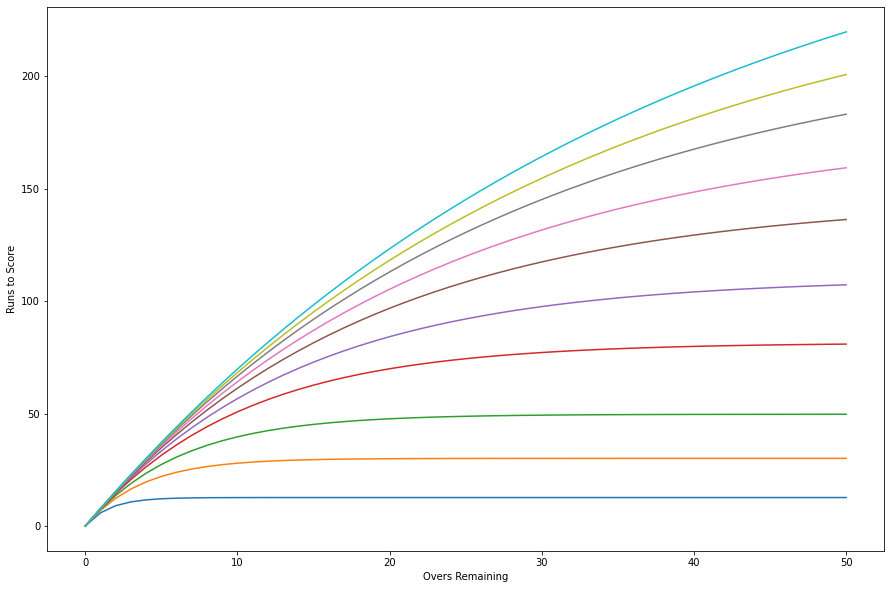

In [40]:
plot(model)

In [74]:
def plot_against_resources(model):
    fig  = plt.figure(figsize= (15,10))
    for i in range(1,11):  #wicket_rem
        u= range(0,51)   #over_rem
        n = len(u)  
        y=[]
        Z = model.x[i-1]
        L = model.x[10]
        #(resource_rem) = run_production_fnc / highest resource
        for j in range(51):
            y.append(100*run_production_function(u[j],Z,L)/highest_score)
        
        plt.plot(u,y)
    plt.ylabel("Resources Remaining")
    plt.xlabel("Overs To go")
    plt.savefig("Resources_vs_over_rem.jpg")

In [75]:

highest_score = run_production_function(50,model.x[9],model.x[10])


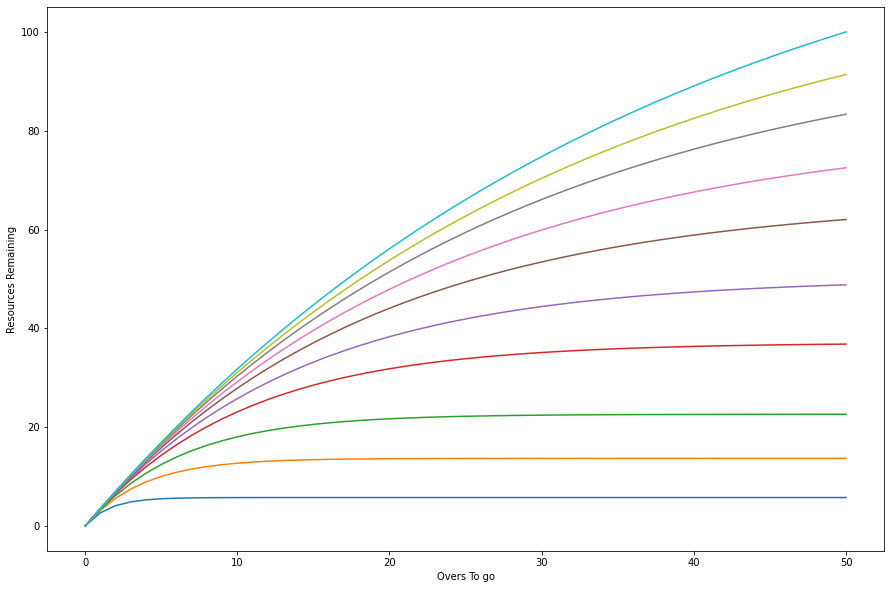

In [76]:
plot_against_resources(model)


In [77]:
print("Z1 ,Z2,Z3....Z10,L parameter values : \n",model.x)
print("Mean Squared Error: ", model.fun)

Z1 ,Z2,Z3....Z10,L parameter values : 
 [ 12.70220754  30.12195838  49.74889013  81.56473891 110.29911713
 145.89550147 178.63033199 218.62495772 253.74095506 298.56179064
   7.9562266 ]
Mean Squared Error:  250564361.17938894
